# Emotion Detection through NLP: ComplementNB vs. RNN and CNN

**Helepers**

In [5]:
import re
import pandas as pd
import seaborn as sns
from typing import Union
import nltk
from nltk import corpus, stem
import numpy as np
from collections import namedtuple

In [15]:
sns.set_style(
    "whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False}
)
sns.set_context(
    "paper", font_scale=2,
    rc={"axes.labelsize": 15, "xtick.labelsize": 15, "ytick.labelsize": 15, 'axes.formatter.min_exponent': 1}
)

In [ ]:
nltk.download('wordnet')
WORD_LEMMA = stem.WordNetLemmatizer()
nltk.download('stopwords')
STOPWORDS = corpus.stopwords.words('english')
nltk.download('punkt')

In [6]:
def load_data(path: str, as_df: bool = True) -> Union[pd.DataFrame, list]:
  ds = []
  with open(f'{path}.txt') as f:
      for line in f: ds.append(line[:-1].split(';', maxsplit=1))
      f.close()
  if not as_df: return ds
  ds = pd.DataFrame(ds, columns=['token', 'label'])
  return ds

In [7]:
def clean_str(token: str) -> str:
    token = re.sub('[^0-9a-zA-Z]', ' ', token)
    token = [WORD_LEMMA.lemmatize(word.lower(), pos='a') for word in token.split() if word not in STOPWORDS]
    return ' '.join(token)

In [13]:
def describe(ds: pd.DataFrame, split_name: str = ''):
    desc = f'_____________________________\n{split_name} description:\n\n' \
           f'Size: {ds.shape[0]}\nNones: {ds.isnull().sum().sum()}\n' \
           f'Target:\n{ds["label"].value_counts()}\n_____________________________'
    print(desc)

In [9]:
def load_DS() -> tuple:
   data = namedtuple('ds', 'train, test, val')
   return data(load_data('train'), load_data('test'), load_data('val'))

In [10]:
LABELS_MAP = {'sadness': 0, 'love': 1, 'anger': 2, 'joy': 3, 'fear': 4, 'surprise': 5}

# Data Preprocessing and Analyzing

In [11]:
DS = load_DS()

In [76]:
print(DS.train.head())

                                               token  label
0                              didnt feel humiliated      0
1  go feeling hopeless damned hopeful around some...      0
2          im grabbing minute post feel greedy wrong      2
3  ever feeling nostalgic fireplace know still pr...      1
4                                    feeling grouchy      2


_____________________________
Train data description:

Size: 16000
Nones: 0
Target:
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64
_____________________________


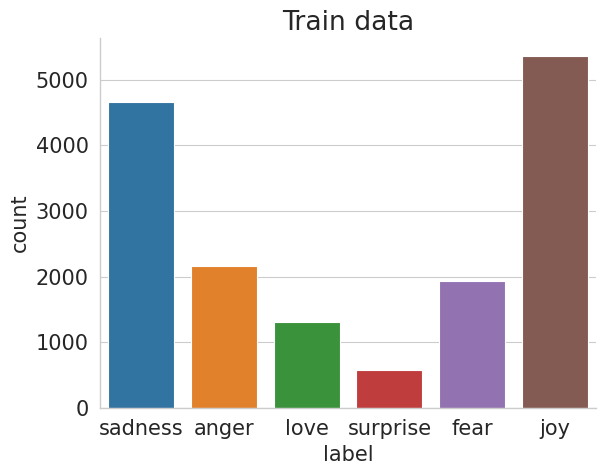

In [16]:
ax = sns.countplot(data=DS.train, x='label')
ax.set_title('Train data')
describe(DS.train, split_name='Train data')

_____________________________
Test data description:

Size: 2000
Nones: 0
Target:
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64
_____________________________


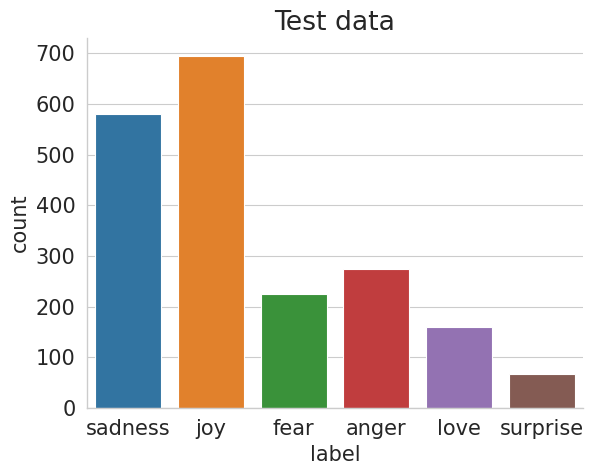

In [17]:
ax = sns.countplot(data=DS.test, x='label')
ax.set_title('Test data')
describe(DS.test, split_name='Test data')

_____________________________
Val data description:

Size: 2000
Nones: 0
Target:
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: label, dtype: int64
_____________________________


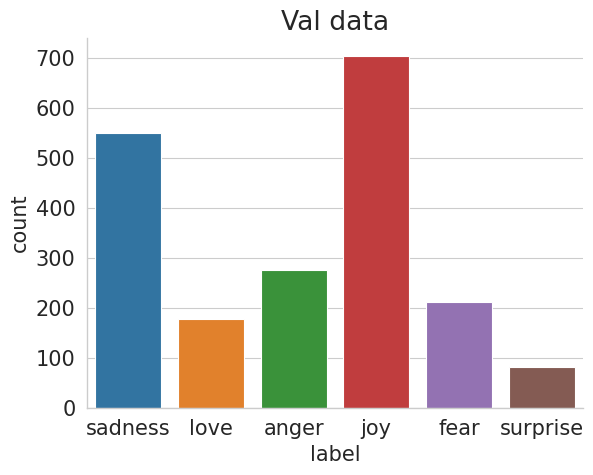

In [18]:
ax = sns.countplot(data=DS.val, x='label')
ax.set_title('Val data')
describe(DS.val, split_name='Val data')

Text(0.5, 1.0, 'Train data befor cleaning')

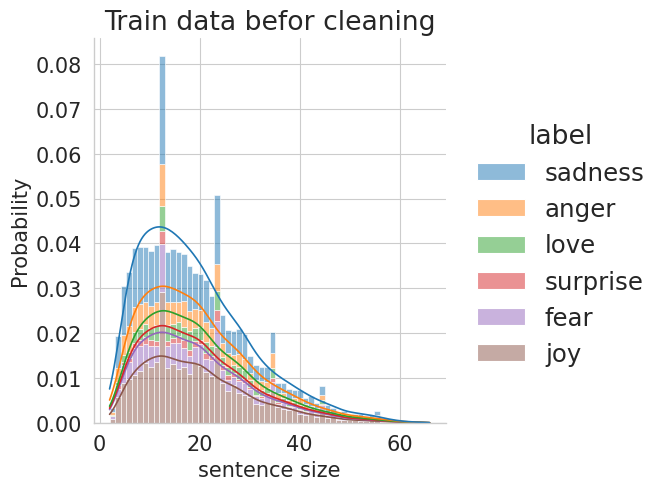

In [19]:
DS.train['sentence size'] = DS.train['token'].apply(lambda s: len(s.split()))
ax = sns.displot(DS.train, x="sentence size", hue='label', kde=True, stat="probability", multiple="stack")
ax.ax.set_title('Train data befor cleaning')

Text(0.5, 1.0, 'Train data after cleaning')

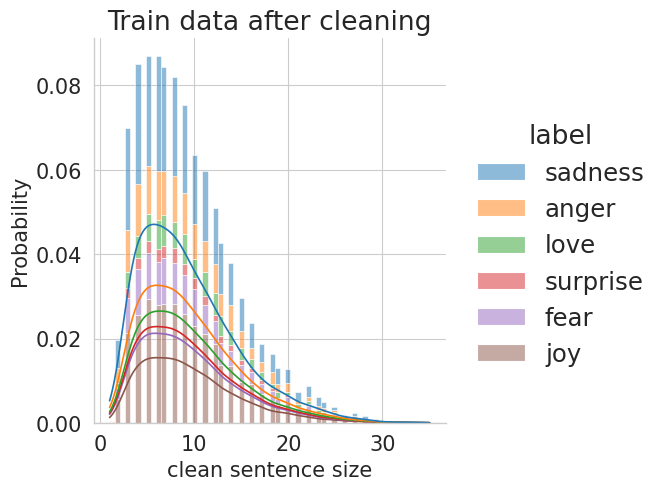

In [20]:
DS.train['token clean'] = DS.train['token'].apply(clean_str)
DS.train['clean sentence size'] = DS.train['token clean'].apply(lambda s: len(s.split()))
ax = sns.displot(DS.train, x="clean sentence size", hue='label', kde=True, stat="probability", multiple="stack")
ax.ax.set_title('Train data after cleaning')

In [28]:
print(f'\nBefore cleaning: \n{DS.train["token"].head()}')
print(f'\nAfter cleaning: \n{DS.train["token clean"].head()}')


Before cleaning: 
0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: token, dtype: object

After cleaning: 
label
sadness                                didnt feel humiliated
sadness    go feeling hopeless damned hopeful around some...
anger              im grabbing minute post feel greedy wrong
love       ever feeling nostalgic fireplace know still pr...
anger                                        feeling grouchy
Name: token clean, dtype: object


Text(0.5, 1.0, 'Test data after cleaning')

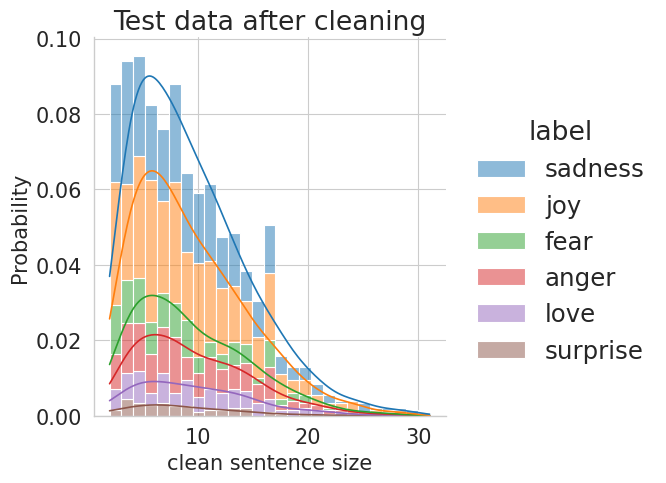

In [21]:
DS.test['token clean'] = DS.test['token'].apply(clean_str)
DS.test['clean sentence size'] = DS.test['token clean'].apply(lambda s: len(s.split()))
ax = sns.displot(DS.test, x="clean sentence size", hue='label', kde=True, stat="probability", multiple="stack")
ax.ax.set_title('Test data after cleaning')

Text(0.5, 1.0, 'Val data after cleaning')

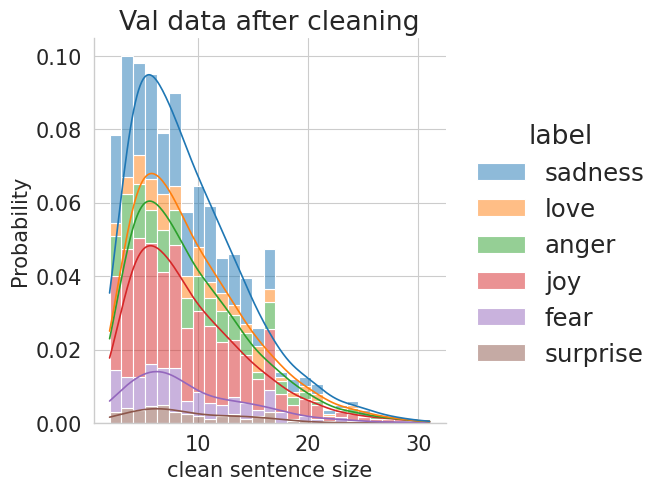

In [22]:
DS.val['token clean'] = DS.val['token'].apply(clean_str)
DS.val['clean sentence size'] = DS.val['token clean'].apply(lambda s: len(s.split()))
ax = sns.displot(DS.val, x="clean sentence size", hue='label', kde=True, stat="probability", multiple="stack")
ax.ax.set_title('Val data after cleaning')

In [23]:
words = DS.train['token clean']
words.index = DS.train['label']
words_group = words.groupby(['label']).apply(lambda y: y.str.cat(sep=' '))

In [24]:
most_common = []
for lab in words_group.index:
    txt = words_group[lab]
    word_dist = nltk.FreqDist(nltk.tokenize.word_tokenize(txt))
    most_common += [[lab, com[0], com[1]] for com in word_dist.most_common(20)]

most_common = pd.DataFrame(most_common, columns=['label', 'word', 'freq'])

In [ ]:
for g, gdf in most_common.groupby(['label']):
  print(f'Label: {g}\n {gdf[["word", "freq"]]}\n\n')

# ComplementNB Classifier

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

In [29]:
DS = load_DS()
for ds in DS:
  ds['token'] = ds['token'].apply(clean_str)
  ds['label'] = ds['label'].map(LABELS_MAP)

**Choosing model**

TF-IDF features

In [ ]:
tv_ds = pd.concat(
    (DS.train, DS.val), axis=0
).reset_index(drop=True)

vectorizer = TfidfVectorizer()
X_tr = vectorizer.fit_transform(tv_ds['token'])
Y_tr = tv_ds['label']

models:

- ComplementNB (Complement Naive Bayes):

    - Effective for handling imbalanced datasets and fast.

- LinearSVC (Linear Support Vector Classifier):
    - Works well for high-dimensional data (big vocabolury) and multiclass classification.

- LogisticRegression:
    - can help in understanding the linear relationships between features and target classes.

- RandomForestClassifier (Ensemble learning):
    - It can capture complex patterns and relationships in the data, including interactions between words in text data

In [46]:
models = [
    (ComplementNB(), 'ComplementNB'),
    (LinearSVC(), 'LinearSVC'),
    (LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg'), 'LogisticRegression'),
    (RandomForestClassifier(n_estimators=100, max_depth=5), 'RandomForest')
]
events = []

In [47]:
for model, name in models:
    eve = cross_validate(model, X_tr, Y_tr, scoring='accuracy', cv=10)
    for i, (acc, t1, t2) in enumerate(zip(eve['test_score'], eve['fit_time'], eve['score_time'])):
      events.append([name, i + 1, t1, t2, acc])

events = pd.DataFrame(events, columns=['Est.', 'CV', 'Fit time', 'Score time', 'Accuracy'])
events['Err'] = events['Est.'].map(events.groupby(['Est.']).apply(lambda x: x['Accuracy'].std()))

In [64]:
print(f"Mean Accuracy:\n {events.groupby(['Est.']).apply(lambda x: x['Accuracy'].mean())}")

Mean Accuracy:
 Est.
ComplementNB          0.881500
LinearSVC             0.894000
LogisticRegression    0.865611
RandomForest          0.341333
dtype: float64


In [65]:
print(f"Mean Err:\n {events.groupby(['Est.']).apply(lambda x: x['Accuracy'].std())}")

Mean Err:
 Est.
ComplementNB          0.006774
LinearSVC             0.008219
LogisticRegression    0.008552
RandomForest          0.001721
dtype: float64


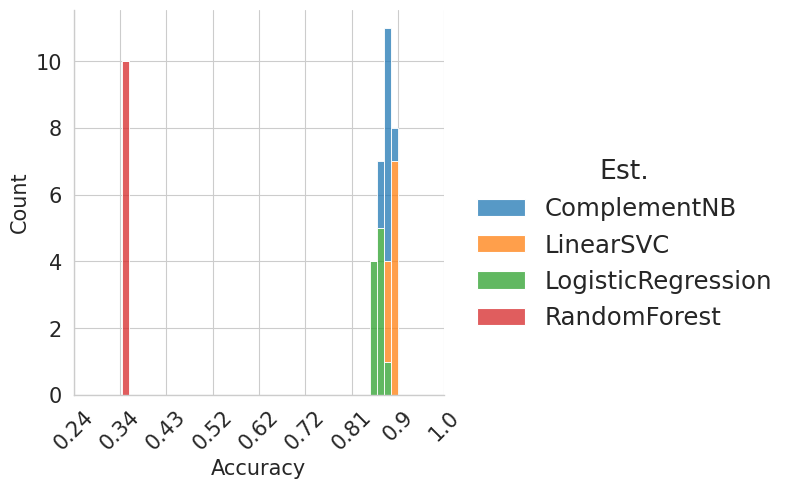

In [53]:
ax = sns.displot(
    events, x="Accuracy", hue="Est.", element='bars', bins=40, multiple="stack"
)
_ = ax.ax.set_xlim([events['Accuracy'].min() - 0.1, 1])
_ = ax.ax.set_xticks(
    np.linspace(events['Accuracy'].min() - 0.1, 1, 9),
    np.round_(np.linspace(events['Accuracy'].min() - 0.1, 1, 9), 2), rotation=45
)

In [66]:
print(f"Mean Fit time:\n {events.groupby(['Est.']).apply(lambda x: x['Fit time'].mean())}")

Mean Fit time:
 Est.
ComplementNB          0.013765
LinearSVC             0.391299
LogisticRegression    1.855470
RandomForest          1.986830
dtype: float64


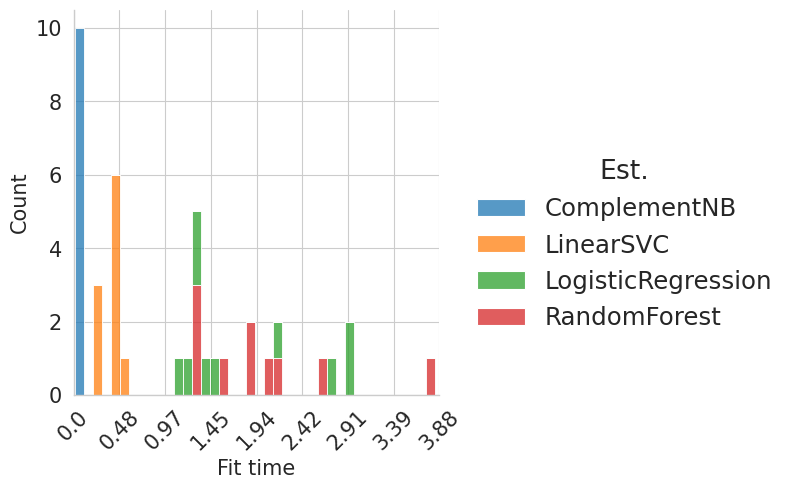

In [54]:
ax = sns.displot(
    events, x="Fit time", hue="Est.", element='bars', bins=40, multiple="stack"
)
_ = ax.ax.set_xlim([0, events['Fit time'].max() + 0.05])
_ = ax.ax.set_xticks(
    np.linspace(0, events['Fit time'].max() + 0.05, 9),
    np.round_(np.linspace(0, events['Fit time'].max() + 0.05, 9), 2), rotation=45
)

In [67]:
print(f"Mean Score time:\n {events.groupby(['Est.']).apply(lambda x: x['Score time'].mean())}")

Mean Score time:
 Est.
ComplementNB          0.002011
LinearSVC             0.002831
LogisticRegression    0.004021
RandomForest          0.036788
dtype: float64


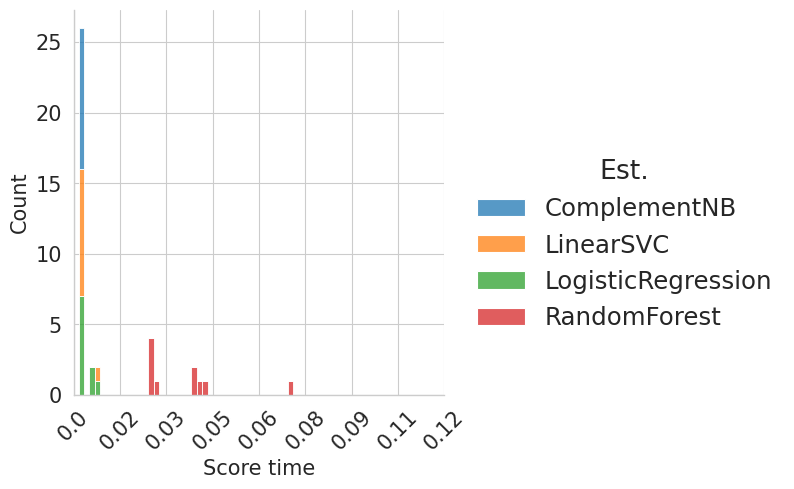

In [55]:
ax = sns.displot(
    events, x="Score time", hue="Est.", element='bars', bins=40, multiple="stack"
)
_ = ax.ax.set_xlim([0, events['Score time'].max() + 0.05])
_ = ax.ax.set_xticks(
    np.linspace(0, events['Score time'].max() + 0.05, 9),
    np.round_(np.linspace(0, events['Score time'].max() + 0.05, 9), 2), rotation=45
)

Hyperparameter tuning for TF-IDF features

In [56]:
pipeline = Pipeline( [("vect", TfidfVectorizer()), ("clf", ComplementNB())])
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "vect__norm": ("l1", "l2"),
    "clf__alpha": np.logspace(-6, 6, 13),
}

In [57]:
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=50,
    random_state=0,
    n_jobs=2,
    verbose=1
)
search.fit(DS.train['token'], DS.train['label'])

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('clf', ComplementNB())]),
                   n_iter=50, n_jobs=2,
                   param_distributions={'clf__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                                        'vect__max_df': (0.2, 0.4, 0.6, 0.8,
                                                         1.0),
                                        'vect__min_df': (1, 3, 5, 10),
                                        'vect__ngram_range': ((1, 1), (1, 2)),
                                        'vect__norm': ('l1', 'l2')},
                   random_state=0, verbose=1)

In [58]:
print("Best parameters combination found:")
best_parameters = search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")
print(
    f"\nAccuracy of the best parameters"
    f": {search.best_score_:.3f}"
)
print(
    f"\nAccuracy of validation:"
    f"{search.score(DS.val['token'], DS.val['label']):.3f}"
)

Best parameters combination found:
clf__alpha: 1.0
vect__max_df: 0.4
vect__min_df: 5
vect__ngram_range: (1, 2)
vect__norm: l1

Accuracy of the best parameters: 0.905

Accuracy of validation:0.908


Final model

In [68]:
pipeline = Pipeline([
    ("vect", TfidfVectorizer(norm='l1', max_df=0.4, min_df=5, ngram_range=(1, 2))),
    ("clf", ComplementNB(alpha=1.0))
])

In [70]:
pipeline.fit(tv_ds['token'], tv_ds['label'])

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.4, min_df=5, ngram_range=(1, 2),
                                 norm='l1')),
                ('clf', ComplementNB())])

In [72]:
y_pred = pipeline.predict(DS.test['token'])

Text(42.91666666666667, 0.5, 'True')

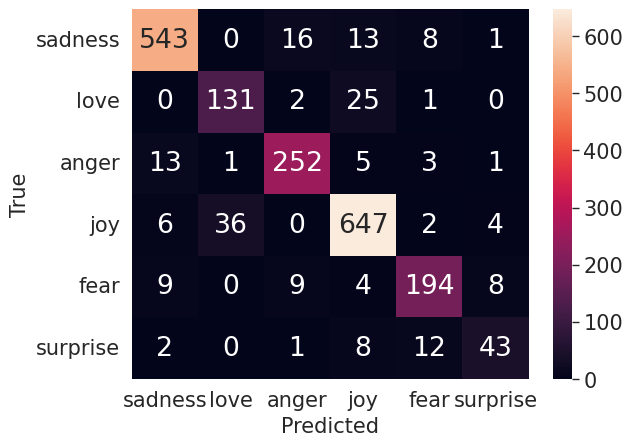

In [75]:
conf_mat = metrics.confusion_matrix(DS.test['label'], y_pred)
ax = sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    xticklabels=list(LABELS_MAP.keys()),
    yticklabels=list(LABELS_MAP.keys())
)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

The substantial overlap in occurrences of "love" and "joy" as false positives can be rationalized, as they are both positive emotions that frequently intersect within the realm of emotional experiences.

# RNN and CNN